In [21]:
import pandas as pd
import sqlite3
import re
# import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# nltk.download()

Lets query our data from the table indeed_jobs that is in the SQLite database named jobs 

In [26]:
# Make a connection to the SQLite db and read in the indeed_jobs
con = sqlite3.connect("data/jobs") #use this for my production environment
# con = sqlite3.connect("jobs") #using this for turning in the project since they will not have the data subfolder
jobs_df = pd.read_sql_query("SELECT * from indeed_jobs", con)
jobs_df.drop(columns=['index'], inplace=True)
con.close()
# If you don't want to connect to the database you can read from the csv saved down on 3/10/22
# jobs_df = pd.read_csv('data/indeed_jobs.csv')

Let drop our duplicates by comparing the job_href column and also drop any entries that doesn't have a job description

In [27]:
# jobs_df = pd.read_csv('data/indeed_jobs.csv') #read in the indeed jobs csv
# jobs_df.drop(columns='Unnamed: 0', inplace=True)
jobs_df = jobs_df.drop_duplicates(subset=['job_href']) #drop duplicates using the job url
jobs_df = jobs_df[jobs_df['job_desc']!='No Job Description'] #drop any jobs that didn't find a job description

We need to catagorize our job titles, just because we searched for data scientist doesn't mean we only received data scientist jobs.  During a search for data scientists, we might get back some software engineer jobs, or during a search for a data engineer role, we might have received a computer engineer role. There are far too many variations of job titles to specify each one so we’ll have to look for our keywords no matter the order (i.e. machine learning engineer is the same as an engineer, machine learning). 

In [28]:
def set_job_category(job_title):
    regex = re.compile('[^a-zA-Z]')
    clean_title = regex.sub('', job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"
jobs_df['job_category'] = jobs_df.loc[:, 'job_title'].apply(set_job_category)

In [29]:
jobs_df['retrieve_date'].value_counts()

2022-02-19    1390
2022-03-05    1365
2022-02-26    1270
2022-02-12    1257
2022-03-14    1181
2022-02-07     765
2022-02-06     648
2022-03-15       6
Name: retrieve_date, dtype: int64

Lets take a look at any of the jobs that are marked 'Other' or 'Software Engineer'

In [17]:
jobs_df['retrieve_date'].tail()

8546    2022-03-05
8547    2022-03-05
8548    2022-03-05
8549    2022-03-05
8550    2022-03-05
Name: retrieve_date, dtype: object

In [5]:
sample_df = jobs_df.loc[jobs_df['job_category'].isin(['Other', 'Software Engineer'])]
sample_df.loc[:,['job_title', 'job_category', 'company_name']].sample(6)

,job_title,job_category,company_name
7041,Technology Analyst (New or Recent Grad),Other,BMO Harris Bank
8270,Research Scientist - Center for Educational In...,Other,North Carolina State University
6227,Director of Decision Support (Business Intelli...,Other,Central City Concern
7693,AI Software Technical Evangelist,Other,Intel
4025,Software Engineer/ Sr Software Engineer (Super...,Software Engineer,BNSF
7895,Budget Analyst,Other,Volunteers of America Oregon


In [6]:
# limit the datafame to the target jobs
target_jobs = ['Data Scientist', 'Business Intelligence Analyst', 'Data Analyst', 'Machine Learning Engineer', 'Data Engineer']
jobs_df = jobs_df[jobs_df['job_category'].isin(target_jobs)].reset_index()

For my analysis I decided to do some research into common languages, cloud computing platforms and tools used by Data Scientists, Data Analysts, Business Intelligence Analysts, Machine Learning Engineers and Data Engineers. Since I have a background as a Data Analyst and Data Scientist my list might be a little bias.

In [7]:
languages = ['sql', 'r', 'c', 'python', 'java', 'nosql', 'scala', 'hql', 'julia', 'sas', 'javascript', 'matlab']
platforms = ['microsoft', 'azure', 'sas', 'gcp', 'google', 'ibm', 'amazon', 'aws', 'oracle', 'apache']
tools = ['splunk', 'cognos', 'mode', 'pytorch', 'hive', 'excel', 'spotfire', 'tibco spotfire', 'scikitlearn', 'toughtspot',
 'access', 'hadoop', 'rapidminer', 'sisense', 'qlikview', 'ibm cognos', 'tableau', 'google data studio', 'word',
 'power bi', 'metabase', 'tensorflow', 'scikit learn', 'sas business intelligence', 'oracle analytics cloud',
 'apache storm', 'analytics cloud', 'redash', 'jupyter notebook', 'IBM Cognos', 'kafka', 'apache spark',
 'powerbi', 'knime', 'sap businessobjects', 'talend', 'powerpoint', 'qlik', 'periscope data', 'spark', 'chartio',
 'domo', 'pig', 'thoughtspot', 'colab', 'looker', 'cassandra', 'elasticsearch', 'mapreduce' ]

lang_plat_tool_words = languages+platforms+tools

Using these words to limit the vocabulary I initialized nltk’s CountVectorizer. I had to enter my own token pattern because it’s default eliminates 1 letter words which I need to include for languages like C or R. I also needed to set ngrams = (1,3) since we have multiple word items in our vocabulary like ‘power bi’ or ‘sas business intelligence’. I then used CountVectorizer to transform the column of job descriptions into a dataframe that has a row for every job description and a column for each word in the vocabulary. The initial transformation has numbers that reference a word as the columns so I needed to replace the numbers with the words and add the job category back so we can group by that when we create our visualizations.

In [8]:
#create our jobs CountVectorizer object that is initialized with ngrams 1-3
# and also only includes words from our list of keywords
job_cv = CountVectorizer(ngram_range=(1,3), vocabulary=set(lang_plat_tool_words),token_pattern=r"(?u)\b\w+\b")

In [9]:
#Transform the job descriptions into a sparse matrix where each row is a document and each column is a token
cv_df = job_cv.transform(jobs_df.loc[:,'job_desc'])
#Turn the sparce matrix into a pandasa dataframe and give it readable column names that relate to the token that the number is for
cv_df = pd.DataFrame(cv_df.toarray(),index=jobs_df.index, columns=job_cv.get_feature_names_out())
# Join the job_category column from the origional dataframe
cv_df = cv_df.join(jobs_df['job_category'])

In [10]:
#The below code is used to combine the cv_df for keywords that reference the same thing and then drops one of the columns
def combine_kw(df):
    df.loc[:,'amazon'] = df.loc[:,'aws']+df.loc[:,'amazon']
    df.loc[:,'google'] = df.loc[:,'gcp']+df.loc[:,'google']
    df.loc[:,'power bi'] = df.loc[:,'powerbi']+df.loc[:,'power bi']
    df.loc['microsoft'] = df.loc[:,'microsoft']+df.loc[:,'azure']
    df.drop(columns=['aws', 'powerbi', 'gcp', 'azure'], inplace=True)
    return df
cv_df = combine_kw(cv_df)

Get the sum of keyword count by job category. We can accomplish this by simply taking the sum after grouping by job category.

In [11]:
cv_sum_df = cv_df.groupby('job_category').sum()


Get the sum of keyword counts divided by number of job postings by job category. We can accomplish this by dividing each row by its respective job category’s entry count.

In [12]:
job_valcnt_df = jobs_df['job_category'].value_counts()
jobs_tfddf_df = cv_sum_df.div(job_valcnt_df, axis=0)

Get the percentage of job postings that included each keyword by job category. We can accomplish this by turning the countvectorized df boolean by making any number bigger than 0 equal to 1. Then do the same as above and divide each row by its respective job category’s entry count.

In [13]:
bool_jobs = cv_df.loc[:,cv_df.columns != 'job_category'].clip(upper=1).copy()
bool_jobs = bool_jobs.join(jobs_df['job_category'])
jobs_perc_df = bool_jobs.groupby('job_category').sum().div(job_valcnt_df, axis=0)

First we’ll visualize the programming languages. Since we’re not positive that all of the languages in our vocabulary were found we need to only include the languages that we found. We’ll then use matplotlib.pyplot to create a figure with 3 plots all in 1 column. We’ll then use pandas internat plotting function to plot each dataframe mentioned above and sort the vocabulary is descending order based on the ‘Data Scientist’ job category. Then we’ll clean it all up by calling tight_layout().

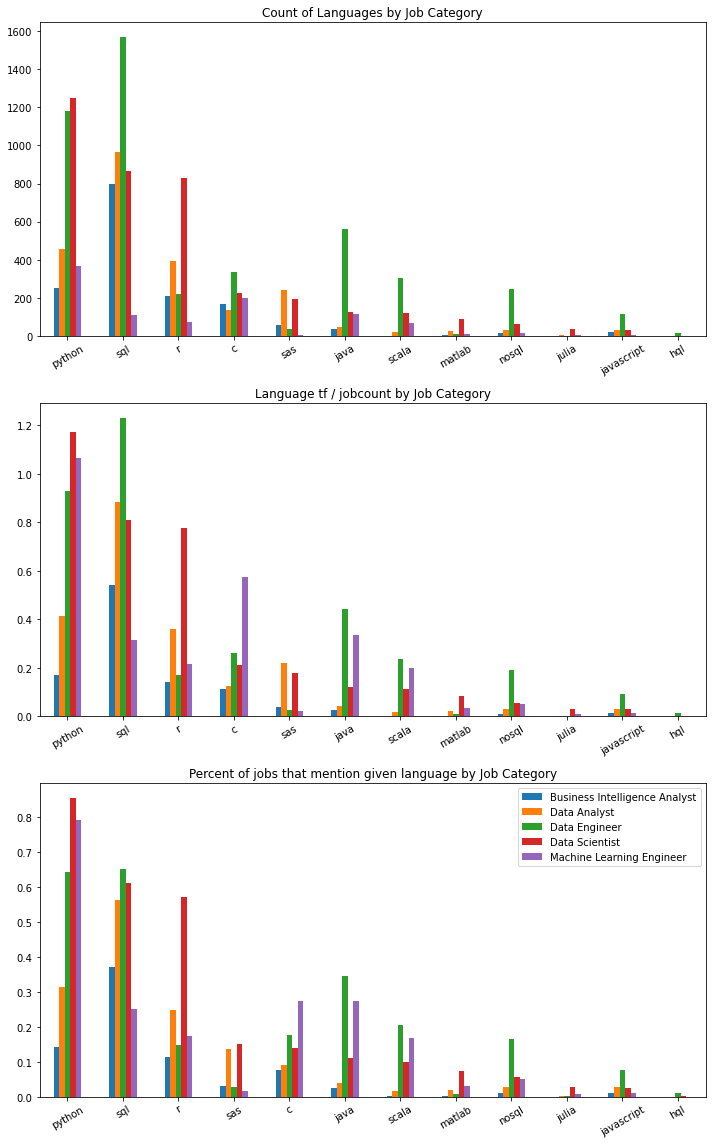

In [14]:
languages_found = list(set(cv_df.columns)&set(languages))
fig, axs = plt.subplots(3,1, figsize=(10,16))
cv_sum_df.T.loc[languages_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Count of Languages by Job Category', sort_columns=True,rot=30,ax=axs[0], legend=False)
jobs_tfddf_df.T.loc[languages_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Language tf / jobcount by Job Category', sort_columns=True,rot=30,ax=axs[1], legend=False)
jobs_perc_df.T.loc[languages_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Percent of jobs that mention given language by Job Category', sort_columns=True,rot=30,ax=axs[2])
fig.tight_layout()
# plt.savefig('images/languages by job category')

For Data Scientists, and Data Engineers top 2 languages to know are Python and SQL. Data Analysts and Business Intelligence Analysts have the same top 2 as Data Scientists and Data Engineers but the demand for them to know python is much lower. It looks like there is a wider language demand for Machine Learning Engineers as their clear #1 is Python but their #2 is close between SQL, C, and Java. One thing that did surprise me is how high the demand is for Data Engineers to know java. 

Next lets visualize cloud platforms. We’ll do it in the same manner as the programming languages but with a different set of vocabulary. 


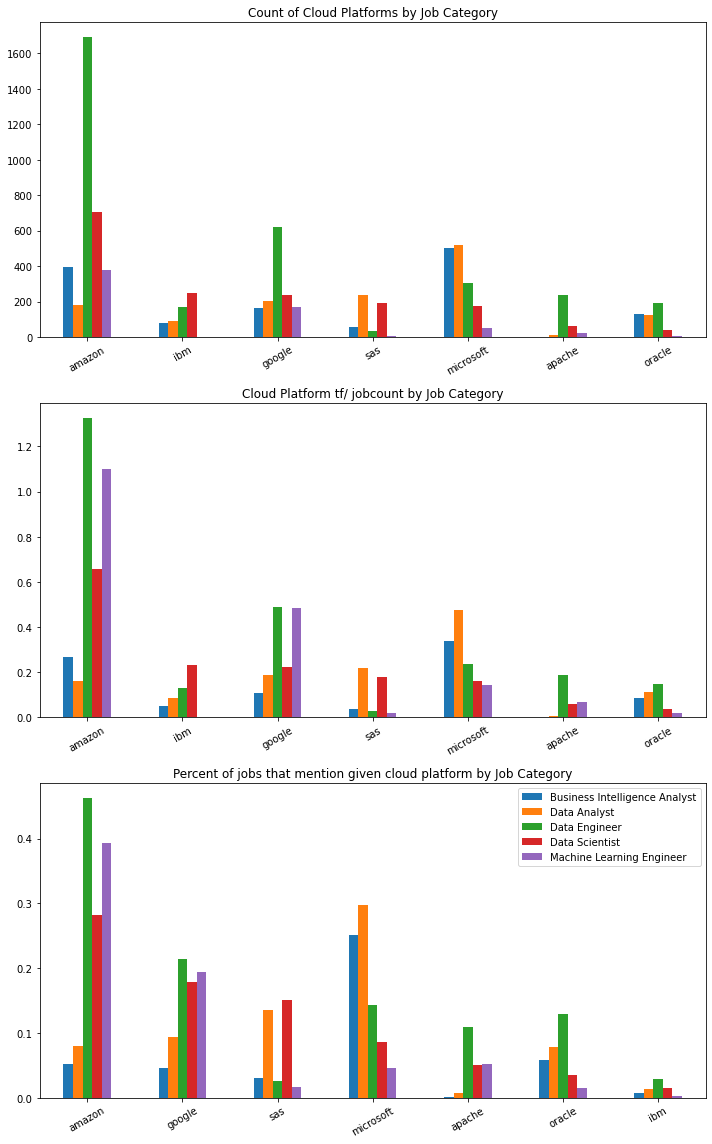

In [15]:
fig, axs = plt.subplots(3,1, figsize=(10,16))
platforms_found = list(set(cv_df.columns)&set(platforms))
cv_sum_df.T.loc[platforms_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Count of Cloud Platforms by Job Category', sort_columns=True,rot=30,ax=axs[0], legend=False)
jobs_tfddf_df.T.loc[platforms_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Cloud Platform tf/ jobcount by Job Category', sort_columns=True,rot=30,ax=axs[1], legend=False)
jobs_perc_df.T.loc[platforms_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(title='Percent of jobs that mention given cloud platform by Job Category', sort_columns=True,rot=30,ax=axs[2])
fig.tight_layout()
plt.savefig('images/platforms by job category')

Amazon and Google are the clear winners for Data Scientists, Data Engineers and Machine Learning Engineers. This is pretty surprising because whenever I see the Cloud Platform market capitalization that Amazon and Microsoft are usually the clear leader with Google lagging behind. I’m also surprised that SAS is mentioned more often for data scientists than Microsoft (including Azure). 

Microsoft is the clear number 1 for Data Analysts and Data Engineers, I expect this is because they’ll be leveraging Microsoft Excel and PowerPoint.

Finally lets visualize the tools, which is really all of the keywords that I found to search that aren’t a programming language or platform. Since we have so many we’ll limit them to the top 15 for data scientists. 


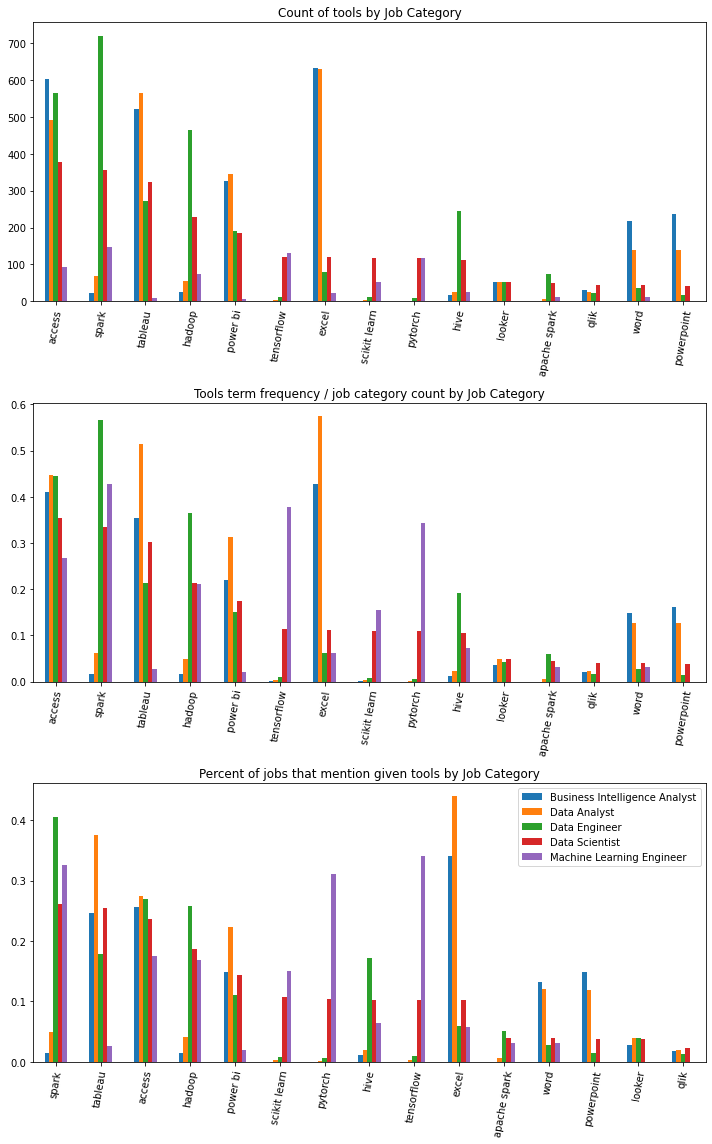

In [16]:
tools_found = list(set(cv_df.columns)&set(tools))
fig, axs = plt.subplots(3,1, figsize=(10,16))
cv_sum_df.T.loc[tools_found,:].sort_values(by=['Data Scientist'],ascending=False).head(15).plot.bar(title='Count of tools by Job Category', sort_columns=True,rot=80,ax=axs[0], legend=False)
jobs_tfddf_df.T.loc[tools_found,:].sort_values(by=['Data Scientist'],ascending=False).head(15).plot.bar(title='Tools term frequency / job category count by Job Category', sort_columns=True,rot=80,ax=axs[1], legend=False)
jobs_perc_df.T.loc[tools_found,:].sort_values(by=['Data Scientist'],ascending=False).head(15).plot.bar(title='Percent of jobs that mention given tools by Job Category', sort_columns=True,rot=80,ax=axs[2])
fig.tight_layout()
# plt.savefig('images/tools by job category')

Its not surprising that the top 5 for Data Science and Data Engineers have to do with storage/database and visualization tools. I am surprised with the difference between how much pytorch and tensorflow is mentioned for Machine Learning Engineers vs Data Scientists. As expected Microsoft Office tools were mentioned much more frequently for Data Analysts and Business Intelligence Analysts than the others. Data Analysts and Business Intelligence Analysts also lead in mentioning Tableau and PowerBI. I am interested in why access is mentioned so much across the board, I included it for Microsoft Access but I will have to look into if its being mentioned in some other reference. 

## Everything below this line is older code that is saved incase for reference
---------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Old Cleaning Method

In [17]:


# def clean_text(text):
#     regex = re.compile('[^a-zA-Z ]')
#     clean_text = regex.sub('', text) #remove punctuation and numbers
#     cl_text = clean_text.lower()
#     tokens = word_tokenize(cl_text)
#     stop_words = set(stopwords.words('english'))
#     words = [w for w in tokens if not w in stop_words]
#     return words

# jobs_df['clean_job_desc'] = jobs_df.loc[:, 'job_desc'].apply(clean_text)

#### Old Bag-of-Words methods

In [18]:
# #Need to look at pulling out bi-grams and tri-grams, we are currently splitting up 
# # machine learning, data science, deep learning, artificial intelligence, power bi
# # neural networks, transfer learning, linear regression, anomaly detection
# # multiple languages,

# import spacy
# from collections import Counter

# ds_bow = []
# for jw_list in jobs_df[jobs_df['job_category']=='Data Scientist'].loc[:,'clean_job_desc']:
#     ds_bow = ds_bow+jw_list
# ds_cv_df = Counter(ds_bow)

# da_bow = []
# for jw_list in jobs_df[jobs_df['job_category']=='Data Analyst'].loc[:,'clean_job_desc']:
#     da_bow = da_bow+jw_list
# da_cv_df = Counter(da_bow)

# from collections import Counter
# cntr = Counter(da_bow)
# cntr.most_common()

### Old Spacy ngrams from noun_chunks

In [19]:
# nlp = spacy.load('en_core_web_sm')
# def spacy_keywords(text):
#     doc = nlp(text)
#     for noun_phrase in list(doc.noun_chunks):
#         noun_phrase.merge(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)
#     return [(token.text,token.pos_) for token in doc]
# sample_ds_df['spacy_noun_chunks2']= sample_ds_df.loc[:, 'job_desc'].apply(spacy_keywords)

# for x in sample_ds_df['spacy_noun_chunks2'][2668]:
#     print(x)

### Old way to graph most popular keywords grouped by job category

In [20]:
# # 
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data scientist
# cv_sum_df.T.nlargest(20,'Data Scientist').plot.bar(figsize=(16,8), title='Top 20 keywords for Data Scientists')
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data engineer
# cv_sum_df.T.nlargest(20,'Data Engineer').plot.bar(figsize=(16,8), title='Top 20 keywords for Data Engineers')
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data Analyst
# cv_sum_df.T.nlargest(20,'Data Analyst').plot.bar(figsize=(16,8), title='Top 20 keywords for Data Analysts')
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data Business Intelligence Analyst
# cv_sum_df.T.nlargest(20,'Business Intelligence Analyst').plot.bar(figsize=(16,8), title='Top 20 keywords for Business Intelligence Analysts')
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for Machine Learning Engineer
# cv_sum_df.T.nlargest(20,'Machine Learning Engineer').plot.bar(figsize=(16,8), title='Top 20 keywords for Machine Learning Engineers')
# plt.show()

### Old Job Category

In [21]:
# def set_job_category(job_title):
#     data_scientist = ["applied", "science", "scientist", "vision", "statistician", 'statistical']
#     bi_analyst = ["business", "intelligence"]
#     data_analyst = ["analyst", "analytics"]
#     ml_engineer = ["machine", "learning"]
#     software_engineer = ["software", "front", "ruby", "stack"]
#     data_engineer = ["engineer"]
#     data_architect = ['architect']
#     regex = re.compile('[^a-zA-Z]')
#     clean_title = regex.sub('', job_title)
#     clean_title = clean_title.lower()
#     if any(x in clean_title for x in data_scientist):
#         return "Data Scientist"
#     elif any(x in clean_title for x in bi_analyst):
#         return "Business Intelligence Analyst"
#     elif any(x in clean_title for x in data_analyst):
#         return "Data Analyst"
#     elif any(x in clean_title for x in ml_engineer):
#         return "Machine Learning Engineer"
#     elif any(x in clean_title for x in software_engineer):
#         return "Software Engineer"
#     elif any(x in clean_title for x in data_engineer):
#         return "Data Engineer"
#     elif any(x in clean_title for x in data_architect):
#         return "Data Architect"
#     else:
#         return "Other"
# jobs_df['job_category'] = jobs_df.loc[:, 'job_title'].apply(set_job_category)

In [22]:
# ds_words = ['SQL', 'Excel', 'PowerPoint', 'R', 'Python', 'PowerBI', 'Tableau', 'Microsoft Office', 'Word', 
#         'sas', 'agile', 'c', 'visualizations', 'hadoop', 'databases', 'data analysis', 'pytorch', 
#         'optimize', 'pandas', 'deployment', 'gcp', 'azure', 'aws', 'mining', 'ibm', 'amazon', 'networks',
#         'classification', 'java', 'scikitlearn', 'transfer', 'tensorflow', 'visualization', 'google', 
#         'supervised', 'unsupervised', 'reinforcement', 'scikit learn', 'pytorch', 
#         'Weka', 'KNIME', 'colab', 'keras', 'shogun', 'catalyst', 'xgboost', 'lightgbm',
#         'catboost', 'stata', 'microsoft']
# ds_words = [word.lower() for word in ds_words]

# da_words = ['Python', 'R', 'SAS', 'Excel', 'access', 'Power BI', 'Tableau', 'Apache Spark',
#         'RapidMiner', 'KNIME', 'QlikView', 'Talend', 'Splunk', 'SAP BusinessObjects',
#         'Sisense', 'TIBCO Spotfire', 'Toughtspot', 'Qlik', 'SAS Business Intelligence',
#         'Google Data Studio', 'Redash', 'Periscope Data', 'Metabase', 'Jupyter Notebook',
#         'IBM Cognos', 'Chartio', 'Mode', 'Looker', 'Domo', 'Oracle Analytics Cloud', 
#         'PIG', 'HIVE', 'Apache Storm' 
#         ]
# da_words = [word.lower() for word in da_words]
# de_words = ['python', 'sql', 'postgresql', 'mongodb', 'spark', 'apache kafka', 'amazon', 
#         'redshift', 'snowflake', 'athena', 'airflow', 'hevo data', 'apache',
#         'bigquery', 'fivetran', 'dbt', 'cloudera data', 'hadoop', 'cassandra',
#         'kudu', 'hive', 'turbine', 'looker', 'segment', 'stitch', 'periscope',
#         'mode', 'presto', 'databand', 'nosql', 'scala', 'hql',
#         ]
# de_words = [word.lower() for word in de_words]

# mass_words = ds_words+da_words+de_words
# languages = ['sql', 'r', 'c', 'python', 'java', 'nosql', 'scala', 'hql', 'julia', 'sas', 'javascript', 'matlab', 'lua', 'perl', 'php', 'ruby']
# platforms = ['microsoft', 'azure', 'sas', 'gcp', 'google', 'ibm', 'amazon', 'aws', 'oracle', 'apache']
# tools = [word for word in mass_words if (word not in languages)&(word not in platforms)]

Old method for graphing

In [23]:
# jobs_tfddf_df.T.loc[languages,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(figsize=(16,10), title='Language term frequency / job category count by Job Category', sort_columns=True,rot=30)
# plt.show()
# platforms_found = list(set(cv_df.columns)&set(platforms))
# jobs_tfddf_df.T.loc[platforms_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(figsize=(16,10), title='Platform term frequency / job category count by Job Category', sort_columns=True,rot=30)
# plt.show()
# tools_found = list(set(cv_df.columns)&set(tools))
# jobs_tfddf_df.T.loc[tools_found,:].sort_values(by=['Data Scientist'],ascending=False).head(15).plot.bar(figsize=(16,10), title='Tools term frequency / job category count by Job Category', sort_columns=True,rot=30)
# # # plt.savefig('jobs_tools')
# plt.show()

#### Graph out the keywords for each kw group that we created

In [24]:
# cv_sum_df.T.loc[languages,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(figsize=(16,10), title='Count of Languages by Job Category', sort_columns=True,rot=30)
# # plt.savefig('job_languages')
# plt.show()
# platforms_found = list(set(cv_df.columns)&set(platforms))
# cv_sum_df.T.loc[platforms_found,:].sort_values(by=['Data Scientist'],ascending=False).plot.bar(figsize=(16,10), title='Count of Platforms by Job Category', sort_columns=True,rot=30)
# # plt.savefig('jobs_platforms')
# plt.show()
# tools_found = list(set(cv_df.columns)&set(tools))
# cv_sum_df.T.loc[tools_found,:].sort_values(by=['Data Scientist'],ascending=False).head(15).plot.bar(figsize=(16,10), title='Count of Tools by Job Category', sort_columns=True,rot=30)
# # plt.savefig('jobs_tools')
# plt.show()


#### Graph out the 20 largest keywords for each job category

In [25]:

# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data scientist
# cv_sum_df.T.nlargest(20,'Data Scientist').loc[:,'Data Scientist'].plot.bar(figsize=(16,8), title='Top 20 keywords for Data Scientists',rot=30)
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data engineer
# cv_sum_df.T.nlargest(20,'Data Engineer').loc[:,'Data Engineer'].plot.bar(figsize=(16,8), title='Top 20 keywords for Data Engineers',rot=30)
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data Analyst
# cv_sum_df.T.nlargest(20,'Data Analyst').loc[:,'Data Analyst'].plot.bar(figsize=(16,8), title='Top 20 keywords for Data Analysts',rot=30)
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for data Business Intelligence Analyst
# cv_sum_df.T.nlargest(20,'Business Intelligence Analyst').loc[:,'Business Intelligence Analyst'].plot.bar(figsize=(16,8), title='Top 20 keywords for Business Intelligence Analysts',rot=30)
# plt.show()
# #plot the cv_df grouped by job_category, we're only going to grab the 20 largest words for Machine Learning Engineer
# cv_sum_df.T.nlargest(20,'Machine Learning Engineer').loc[:,'Machine Learning Engineer'].plot.bar(figsize=(16,8), title='Top 20 keywords for Machine Learning Engineers',rot=30)
# plt.show()